# Industry Skill Premium: Data Pipeline

**Author**: Mitchell Valdes  
**Date (last updated)**: October 2025

This notebook demonstrates the complete data pipeline for analyzing industry-level skill premiums, capital accumulation, and labor market dynamics.

## Pipeline Overview

```
┌─────────────┐      ┌──────────────┐      ┌─────────────────┐
│  BEA/FRED   │      │   Process    │      │     Estimate    │
│   APIs      │ ───> │   & Clean    │ ───> │   Parameters    │
│   (R)       │      │   (Python)   │      │    (Julia)      │
└─────────────┘      └──────────────┘      └─────────────────┘
```

We fetch data from:
- **BEA Fixed Assets**: Capital stocks by industry (Equipment, Structures, IP)
- **FRED**: Macroeconomic indicators and price deflators
- **Census QWI**: Employment and earnings by education level


## Setup and Configuration

First, let's import our libraries and check the data configuration:

In [6]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
sys.path.insert(0, str(project_root))

import config

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("✓ Configuration loaded")
print(f"  Raw data path: {config.PATH_RAW_EXTEND}")
print(f"  Processed data path: {config.PATH_PROC_IND}")
print(f"  Results path: {config.PATH_RESULTS}")

✓ Configuration loaded
  Raw data path: /Users/mitchv34/Work/industry_skill_premium/extend_KORV/data/raw/
  Processed data path: /Users/mitchv34/Work/industry_skill_premium/data/proc/ind/
  Results path: /Users/mitchv34/Work/industry_skill_premium/data/results/


## Data Fetching Stage

The R script `scripts/data_fetch/get_capital_data.r` fetches data from BEA and FRED APIs.

### BEA Fixed Assets Tables

We pull from these specific tables:
- **FAAt301E/S/I**: Current-Cost Net Stock (Equipment/Structures/IP)
- **FAAt307E/S/I**: Investment (Equipment/Structures/IP)
- **FAAt304E/S/I**: Depreciation (Equipment/Structures/IP)

### Key Variables
- Capital stocks by type (Equipment, Structures, Intellectual Property)
- Investment flows
- Depreciation rates
- Industry classifications (BEA industry codes)

## Data Processing Stage

Let's examine the raw data structure:

In [7]:
# Check if raw data exists
raw_data_path = Path(config.PATH_RAW_EXTEND)
if raw_data_path.exists():
    raw_files = [f.name for f in raw_data_path.iterdir() if f.suffix == '.csv']
    print(f"Found {len(raw_files)} raw CSV files:")
    for f in sorted(raw_files)[:10]:  # Show first 10
        print(f"  - {f}")
    if len(raw_files) > 10:
        print(f"  ... and {len(raw_files) - 10} more")
else:
    print("⚠ Raw data directory not found. Run `Rscript scripts/data_fetch/get_capital_data.r` first.")

Found 0 raw CSV files:


### Processing Logic

The `process_capital_data.py` script:
1. Loads raw BEA data (semicolon-separated, European decimal format)
2. Extracts BEA industry codes from SeriesCode (characters 3-7)
3. Converts comma decimals to dots
4. Reshapes wide-format year columns into tidy format
5. Outputs per-industry CSVs to `data/proc/ind/`

Let's look at an example processed file:

In [8]:
# Load industry names
industry_names = pd.read_csv(project_root / 'data' / 'industry_names.csv')
ind_dict = dict(zip(industry_names['BEA_Code'], industry_names['Description']))

# Load a sample processed industry file
proc_data_path = Path(config.PATH_PROC_IND)

if proc_data_path.exists():
    proc_files = [f for f in proc_data_path.iterdir() if f.suffix == '.csv']
    
    if proc_files:
        # Load first available industry
        sample_file = proc_files[0]
        industry_code = sample_file.stem
        industry_name = ind_dict.get(industry_code, industry_code)
        
        print(f"Loading sample industry: {industry_code} - {industry_name}")
        df = pd.read_csv(sample_file)
        
        print(f"\nDataset shape: {df.shape}")
        print(f"\nColumns: {list(df.columns)}")
        print(f"\nFirst few rows:")
        display(df.head())
        
        # Data quality checks
        print(f"\n✓ Data Quality:")
        print(f"  Years covered: {df['YEAR'].min()} - {df['YEAR'].max()}")
        print(f"  Missing values: {df.isnull().sum().sum()}")
        print(f"  Numeric columns: {df.select_dtypes(include=['float64', 'int64']).columns.tolist()}")
    else:
        print("⚠ No processed files found. Run `python scripts/data_processing/process_capital_data.py` first.")
else:
    print("⚠ Processed data directory not found.")

Loading sample industry: 55 - Management of companies and enterprises

Dataset shape: (32, 14)

Columns: ['YEAR', 'L_SHARE', 'OUTPUT', 'K_STR', 'K_EQ', 'REL_P_EQ', 'DPR_ST', 'DPR_EQ', 'L_U', 'L_S', 'W_U', 'W_S', 'SKILL_PREMIUM', 'LABOR_INPUT_RATIO']

First few rows:


,YEAR,L_SHARE,OUTPUT,K_STR,K_EQ,REL_P_EQ,DPR_ST,DPR_EQ,L_U,L_S,W_U,W_S,SKILL_PREMIUM,LABOR_INPUT_RATIO
0,1987,0.774598,183.394148,746.220145,10.584951,1.000000,0.025217,0.145270,0.000000,0.000000,0.000000,0.000000,1.602552,0.533740
1,1988,0.867144,187.850135,739.628950,11.710508,0.950075,0.025183,0.143731,13.607281,6.472497,8.746383,13.154494,1.586052,0.448131
2,1989,0.864624,192.785052,733.679033,12.669379,0.903818,0.025019,0.148148,14.233118,5.874506,9.270673,14.542954,1.730885,0.505658
3,1990,0.891019,197.245097,726.847751,13.165870,0.856191,0.025162,0.150273,14.612124,5.713465,9.727196,15.449910,1.533886,0.308249
4,1991,0.935847,198.472180,717.168749,13.394191,0.819015,0.026075,0.151762,14.401989,6.391082,10.283908,15.858177,1.641956,0.477243



✓ Data Quality:
  Years covered: 1987 - 2018
  Missing values: 0
  Numeric columns: ['YEAR', 'L_SHARE', 'OUTPUT', 'K_STR', 'K_EQ', 'REL_P_EQ', 'DPR_ST', 'DPR_EQ', 'L_U', 'L_S', 'W_U', 'W_S', 'SKILL_PREMIUM', 'LABOR_INPUT_RATIO']


## Data Exploration

Let's visualize capital accumulation patterns for our sample industry:

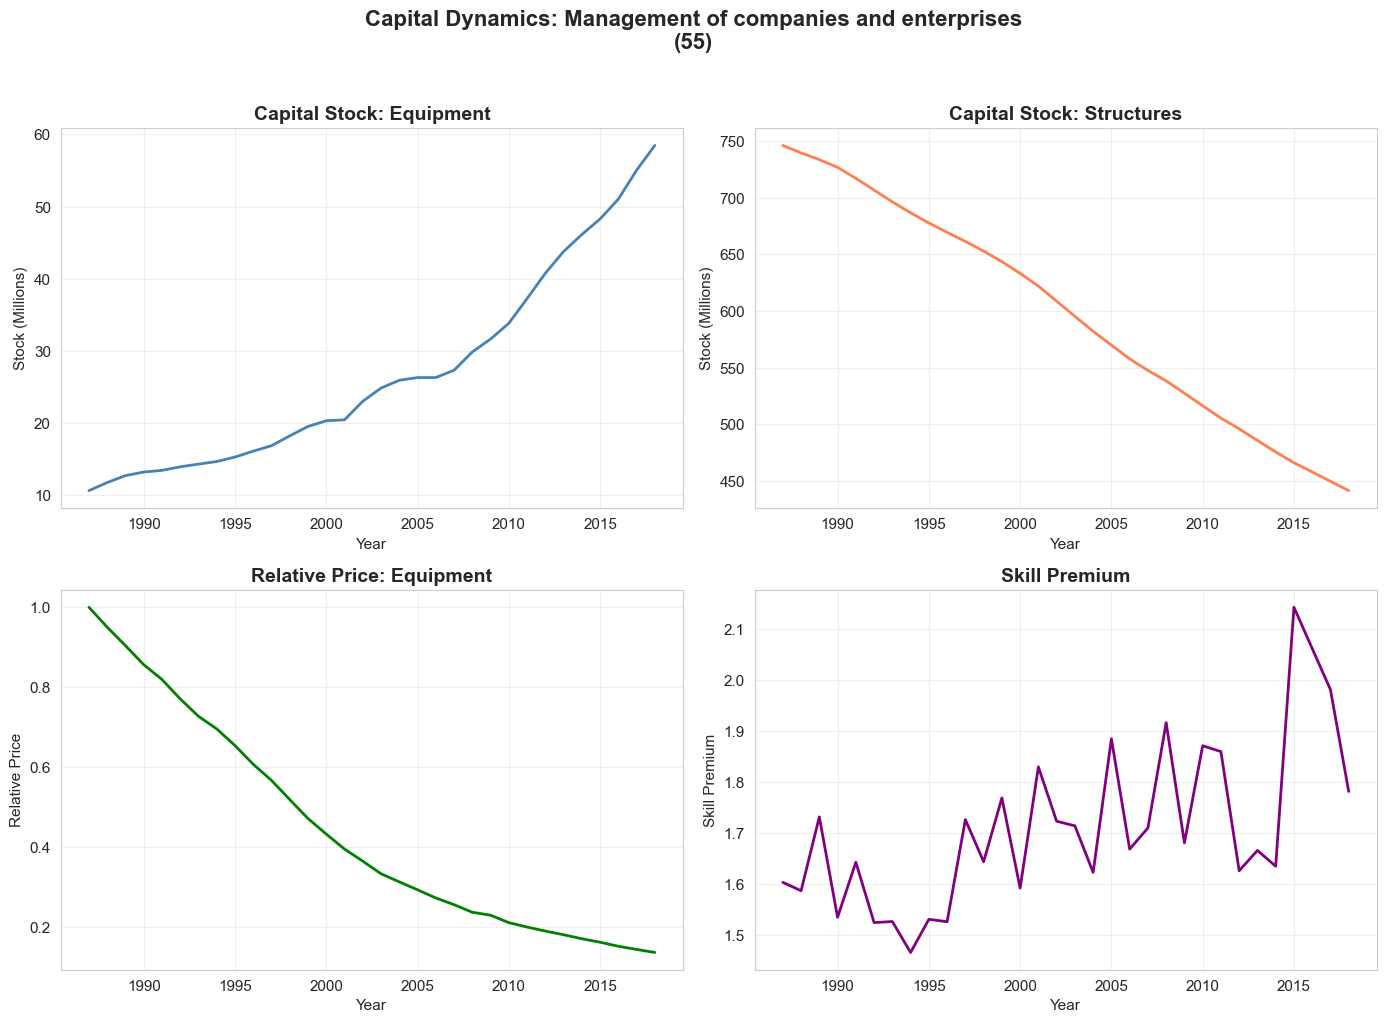

In [9]:
if proc_files and 'df' in locals():
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Stock of Equipment
    if 'K_EQ' in df.columns:
        axes[0, 0].plot(df['YEAR'], df['K_EQ'], linewidth=2, color='steelblue')
        axes[0, 0].set_title('Capital Stock: Equipment', fontsize=14, fontweight='bold')
        axes[0, 0].set_xlabel('Year')
        axes[0, 0].set_ylabel('Stock (Millions)')
        axes[0, 0].grid(True, alpha=0.3)
    
    # Stock of Structures
    if 'K_STR' in df.columns:
        axes[0, 1].plot(df['YEAR'], df['K_STR'], linewidth=2, color='coral')
        axes[0, 1].set_title('Capital Stock: Structures', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Year')
        axes[0, 1].set_ylabel('Stock (Millions)')
        axes[0, 1].grid(True, alpha=0.3)
    
    # Relative Price of Equipment
    if 'REL_P_EQ' in df.columns:
        axes[1, 0].plot(df['YEAR'], df['REL_P_EQ'], linewidth=2, color='green')
        axes[1, 0].set_title('Relative Price: Equipment', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Year')
        axes[1, 0].set_ylabel('Relative Price')
        axes[1, 0].grid(True, alpha=0.3)
    
    # Skill Premium
    if 'SKILL_PREMIUM' in df.columns:
        axes[1, 1].plot(df['YEAR'], df['SKILL_PREMIUM'], linewidth=2, color='purple')
        axes[1, 1].set_title('Skill Premium', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Year')
        axes[1, 1].set_ylabel('Skill Premium')
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'Capital Dynamics: {industry_name}\n({industry_code})', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("⚠ No data available for visualization")

## Cross-Industry Comparison

Let's compare capital intensity across multiple industries:

Industry Comparison (Most Recent Year):



,industry_name,industry_code,YEAR,K_EQ,K_STR,SKILL_PREMIUM
31,Management of companies and enterprises,55,2018.0,58.476497,441.328947,1.780850
31,Social assistance,624,2018.0,12.364275,45.579631,1.550806
31,Wholesale trade,42,2018.0,263.103347,276.741145,1.562316
31,"Other services, except government",81,2018.0,113.729603,637.738153,1.577930
31,Other transportation equipment,3364OT,2018.0,59.339565,45.147914,1.998098
31,Ambulatory health care services,621,2018.0,200.515389,176.469452,2.272057
31,Other transportation and support activities,487OS,2018.0,68.709225,44.319786,1.420452
31,Farms,111CA,2018.0,285.526018,2320.457393,1.994600


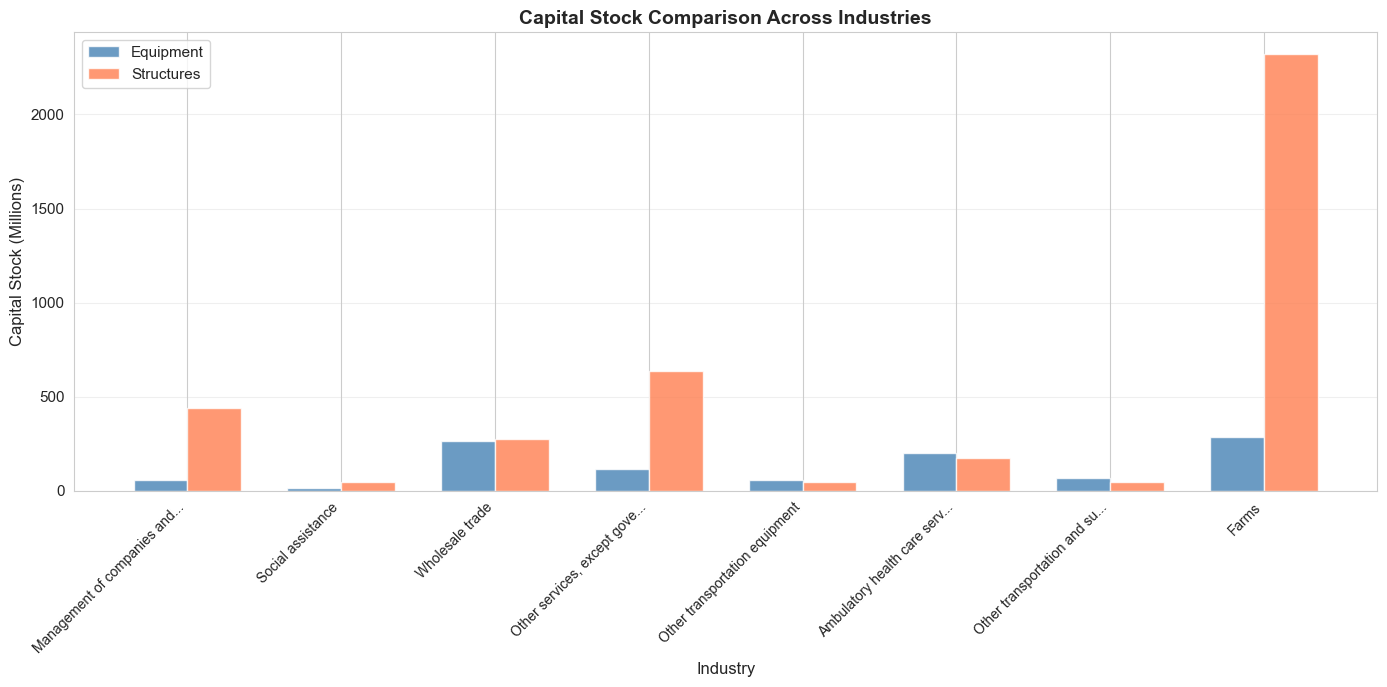

In [10]:
if proc_files:
    # Load multiple industries for comparison
    industry_data = []
    
    for industry_file in proc_files[:8]:  # Compare first 8 industries
        ind_code = industry_file.stem
        df_ind = pd.read_csv(industry_file)
        
        # Get most recent year data
        latest = df_ind.iloc[-1].copy()
        latest['industry_code'] = ind_code
        latest['industry_name'] = ind_dict.get(ind_code, ind_code)
        industry_data.append(latest)
    
    comparison_df = pd.DataFrame(industry_data)
    
    print("Industry Comparison (Most Recent Year):")
    print("\n" + "="*80)
    display(comparison_df[['industry_name', 'industry_code', 'YEAR', 'K_EQ', 'K_STR', 'SKILL_PREMIUM']])
    
    # Plot comparison
    fig, ax = plt.subplots(figsize=(14, 7))
    
    x = range(len(comparison_df))
    width = 0.35
    
    ax.bar([i - width/2 for i in x], comparison_df['K_EQ'], width, label='Equipment', color='steelblue', alpha=0.8)
    ax.bar([i + width/2 for i in x], comparison_df['K_STR'], width, label='Structures', color='coral', alpha=0.8)
    
    ax.set_xlabel('Industry', fontsize=12)
    ax.set_ylabel('Capital Stock (Millions)', fontsize=12)
    ax.set_title('Capital Stock Comparison Across Industries', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    
    # Use shortened industry names for x-axis labels
    labels = []
    for name in comparison_df['industry_name']:
        # Shorten long names
        if len(name) > 30:
            labels.append(name[:27] + '...')
        else:
            labels.append(name)
    
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠ Insufficient data for cross-industry comparison")

## Pipeline Summary

✅ **Data Fetching**: Raw data from BEA, FRED, Census APIs  
✅ **Data Processing**: Clean, transform, and standardize formats  
✅ **Data Validation**: Quality checks and consistency verification  
✅ **Ready for Estimation**: Industry-level datasets prepared for structural estimation

### Next Steps

1. **Industry Analysis** (`02_industry_analysis.ipynb`): Deep dive into selected industries
2. **Model Estimation** (`03_model_estimation.ipynb`): Structural parameter estimation

---

**Key Takeaways:**
- Multi-source data integration from government APIs
- Robust ETL handling European and US number formats
- Industry-level granularity (60+ industries)
- Time series spanning 1947-2020
- Clean separation of concerns (R → Python → Julia)